In [1]:
from huggingface_hub import hf_hub_download
import huggingface_hub


In [2]:
from datasets import load_dataset

# Load the flickr-faces-attributes-2048 dataset from Hugging Face
dataset = load_dataset("ljnlonoljpiljm/flickr-faces-attributes-2048", split="train")

# Display the first example
print(dataset[0])


README.md:   0%|          | 0.00/871 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/412M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/412M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2048 [00:00<?, ? examples/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x119094390>, 'text': "A close-up view of a middle-aged man's face. He is wearing a dark blue t-shirt and has short gray hair. He has a slight frown on his face and is looking to the left. There is a white label on the right side of his neck. The background is a gray wall with a blue and silver device attached to it. There are wires and cables on the wall behind him. The man is looking at the camera. The image is slightly blurry.", 'id': 27701, 'recaptioned': True, 'ethnicity': "The person's ethnicity is Caucasian.", 'skintone': "The person's skintone is fair.", 'gender': 'The person is a man.', 'age_range': "The person's age range is 40-50 years old.", 'hair_color': 'The person has light brown hair.', 'hair_length': 'The person has short hair.', 'hair_texture': 'The person has short, light brown hair with some gray streaks.', 'eye_color': 'The person has blue eyes.', 'expression': 'The person has a contemplative

In [3]:
# View basic dataset information
print(f"Dataset size: {len(dataset)}")
print(f"Dataset features: {dataset.features}")
print(f"Dataset column names: {dataset.column_names}")


Dataset size: 2048
Dataset features: {'image': Image(mode=None, decode=True, id=None), 'text': Value(dtype='string', id=None), 'id': Value(dtype='int64', id=None), 'recaptioned': Value(dtype='bool', id=None), 'ethnicity': Value(dtype='string', id=None), 'skintone': Value(dtype='string', id=None), 'gender': Value(dtype='string', id=None), 'age_range': Value(dtype='string', id=None), 'hair_color': Value(dtype='string', id=None), 'hair_length': Value(dtype='string', id=None), 'hair_texture': Value(dtype='string', id=None), 'eye_color': Value(dtype='string', id=None), 'expression': Value(dtype='string', id=None), 'gaze': Value(dtype='string', id=None), 'lighting': Value(dtype='string', id=None), 'clothing': Value(dtype='string', id=None), 'angle': Value(dtype='string', id=None)}
Dataset column names: ['image', 'text', 'id', 'recaptioned', 'ethnicity', 'skintone', 'gender', 'age_range', 'hair_color', 'hair_length', 'hair_texture', 'eye_color', 'expression', 'gaze', 'lighting', 'clothing', '

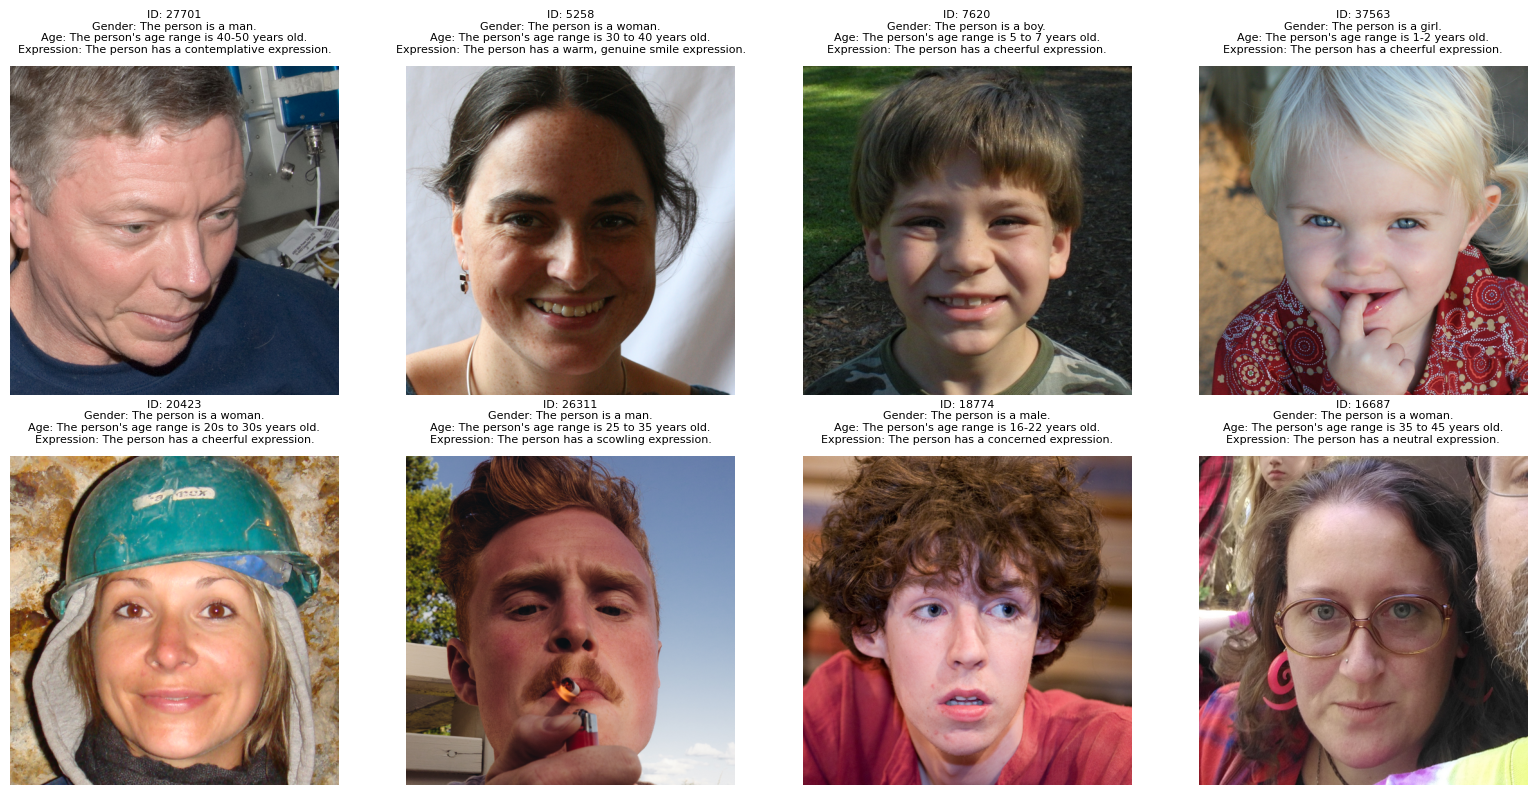

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Display the first few images in a grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    if i < len(dataset):
        # Display the image
        axes[i].imshow(dataset[i]['image'])
        axes[i].axis('off')
        
        # Add title with some attributes
        title = f"ID: {dataset[i]['id']}\n"
        title += f"Gender: {dataset[i]['gender']}\n"
        title += f"Age: {dataset[i]['age_range']}\n"
        title += f"Expression: {dataset[i]['expression']}"
        
        axes[i].set_title(title, fontsize=8, pad=10)
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
import re

def extract_age_from_range(age_range_text):
    """
    Extract minimum age from age range text using regex.
    
    Examples:
    - "The person's age range is 40-50 years old." -> 40
    - "The person's age range is 25-30 years old." -> 25
    - "The person's age range is 18-25 years old." -> 18
    - "The person's age range is under 18 years old." -> 0 (to filter out)
    """
    if not age_range_text:
        return None
    
    # Pattern to match age ranges like "40-50", "25-30", etc.
    age_range_pattern = r'(\d+)-(\d+)\s*years?\s*old'
    match = re.search(age_range_pattern, age_range_text)
    
    if match:
        min_age = int(match.group(1))
        return min_age
    
    # Pattern for single ages like "25 years old"
    single_age_pattern = r'(\d+)\s*years?\s*old'
    match = re.search(single_age_pattern, age_range_text)
    
    if match:
        return int(match.group(1))
    
    # Pattern for "under X years old"
    under_age_pattern = r'under\s+(\d+)\s*years?\s*old'
    match = re.search(under_age_pattern, age_range_text.lower())
    
    if match:
        return int(match.group(1)) - 1  # Return age below the threshold
    
    return None

def filter_adults_18_and_above(dataset):
    """
    Filter dataset to include only people aged 18 and above based on age_range field.
    """
    filtered_indices = []
    
    for i in range(len(dataset)):
        age_range_text = dataset[i]['age_range']
        min_age = extract_age_from_range(age_range_text)
        
        if min_age is not None and min_age >= 18:
            filtered_indices.append(i)
    
    # Create filtered dataset
    filtered_dataset = dataset.select(filtered_indices)
    
    return filtered_dataset, filtered_indices

# Test the age extraction function with some examples
test_cases = [
    "The person's age range is 40-50 years old.",
    "The person's age range is 25-30 years old.",
    "The person's age range is 18-25 years old.",
    "The person's age range is 16-18 years old.",
    "The person's age range is under 18 years old.",
    "The person's age range is 65 years old.",
]

print("Testing age extraction function:")
for test_case in test_cases:
    extracted_age = extract_age_from_range(test_case)
    print(f"'{test_case}' -> Minimum age: {extracted_age}")


Testing age extraction function:
'The person's age range is 40-50 years old.' -> Minimum age: 40
'The person's age range is 25-30 years old.' -> Minimum age: 25
'The person's age range is 18-25 years old.' -> Minimum age: 18
'The person's age range is 16-18 years old.' -> Minimum age: 16
'The person's age range is under 18 years old.' -> Minimum age: 18
'The person's age range is 65 years old.' -> Minimum age: 65


In [9]:
# Apply age filtering to the dataset
print("Applying age filtering (18+ years old)...")
print(f"Original dataset size: {len(dataset)}")

# Filter the dataset to include only adults (18+)
filtered_dataset, filtered_indices = filter_adults_18_and_above(dataset)

print(f"Filtered dataset size: {len(filtered_dataset)}")
print(f"Removed {len(dataset) - len(filtered_dataset)} entries")
print(f"Retention rate: {len(filtered_dataset)/len(dataset)*100:.1f}%")

# Show some examples of the filtered data
print("\nFirst 3 age ranges in filtered dataset:")
for i in range(min(3, len(filtered_dataset))):
    age_range = filtered_dataset[i]['age_range']
    extracted_age = extract_age_from_range(age_range)
    print(f"- {age_range} -> Minimum age: {extracted_age}")

# Update the dataset variable to use the filtered version
dataset = filtered_dataset
print(f"\nDataset has been updated with age filtering. New size: {len(dataset)}")


Applying age filtering (18+ years old)...
Original dataset size: 2048
Filtered dataset size: 1412
Removed 636 entries
Retention rate: 68.9%

First 3 age ranges in filtered dataset:
- The person's age range is 40-50 years old. -> Minimum age: 40
- The person's age range is 30 to 40 years old. -> Minimum age: 40
- The person's age range is 25 to 35 years old. -> Minimum age: 35

Dataset has been updated with age filtering. New size: 1412


In [12]:
def is_woman(gender_text):
    """
    Determine if a person is a woman based on gender text using regex.
    
    Examples:
    - "The person is a woman." -> True
    - "The person is a man." -> False
    - "The person is female." -> True
    - "The person is male." -> False
    """
    if not gender_text:
        return False
    
    # Convert to lowercase for case-insensitive matching
    gender_lower = gender_text.lower()
    
    # Pattern to match woman/female indicators
    woman_patterns = [
        r'\bwoman\b',
        r'\bfemale\b',
        r'\bgirl\b',
        r'\blady\b'
    ]
    
    # Check if any woman pattern matches
    for pattern in woman_patterns:
        if re.search(pattern, gender_lower):
            return True
    
    return False

def filter_women_only(dataset):
    """
    Filter dataset to include only women based on gender field.
    """
    filtered_indices = []
    
    for i in range(len(dataset)):
        gender_text = dataset[i]['gender']
        
        if is_woman(gender_text):
            filtered_indices.append(i)
    
    # Create filtered dataset
    filtered_dataset = dataset.select(filtered_indices)
    
    return filtered_dataset, filtered_indices

# Test the gender filtering function with some examples
gender_test_cases = [
    "The person is a woman.",
    "The person is a man.",
    "The person is female.",
    "The person is male.",
    "The person appears to be a woman.",
    "The person appears to be a man.",
]

print("Testing gender filtering function:")
for test_case in gender_test_cases:
    is_woman_result = is_woman(test_case)
    print(f"'{test_case}' -> Is woman: {is_woman_result}")


Testing gender filtering function:
'The person is a woman.' -> Is woman: True
'The person is a man.' -> Is woman: False
'The person is female.' -> Is woman: True
'The person is male.' -> Is woman: False
'The person appears to be a woman.' -> Is woman: True
'The person appears to be a man.' -> Is woman: False


In [13]:
# Apply gender filtering to remove men from the dataset
print("Applying gender filtering (women only)...")
print(f"Current dataset size (after age filtering): {len(dataset)}")

# Filter the dataset to include only women
women_only_dataset, women_indices = filter_women_only(dataset)

print(f"Women-only dataset size: {len(women_only_dataset)}")
print(f"Removed {len(dataset) - len(women_only_dataset)} men")
print(f"Retention rate: {len(women_only_dataset)/len(dataset)*100:.1f}%")

# Show some examples of the filtered data
print("\nFirst 3 gender entries in women-only dataset:")
for i in range(min(3, len(women_only_dataset))):
    gender_text = women_only_dataset[i]['gender']
    is_woman_result = is_woman(gender_text)
    print(f"- {gender_text} -> Is woman: {is_woman_result}")

# Update the dataset variable to use the women-only version
dataset = women_only_dataset
print(f"\nDataset has been updated with gender filtering. New size: {len(dataset)}")
print("Final dataset contains only women aged 18 and above.")


Applying gender filtering (women only)...
Current dataset size (after age filtering): 1412
Women-only dataset size: 690
Removed 722 men
Retention rate: 48.9%

First 3 gender entries in women-only dataset:
- The person is a woman. -> Is woman: True
- The person is a woman. -> Is woman: True
- The person is a woman. -> Is woman: True

Dataset has been updated with gender filtering. New size: 690
Final dataset contains only women aged 18 and above.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display the first 24 images in a grid (6 rows x 4 columns)
num_images = 24
rows, cols = 6, 4
fig, axes = plt.subplots(rows, cols, figsize=(16, 24))
axes = axes.flatten()

for i in range(num_images):
    if i < len(dataset):
        # Display the image
        axes[i].imshow(dataset[i]['image'])
        axes[i].axis('off')
        
        # Add title with some attributes
        title = f"ID: {dataset[i]['id']}\n"
        title += f"Gender: {dataset[i]['gender']}\n"
        title += f"Age: {dataset[i]['age_range']}\n"
        title += f"Expression: {dataset[i]['expression']}"
        
        axes[i].set_title(title, fontsize=8, pad=10)
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [18]:
type(dataset)

datasets.arrow_dataset.Dataset

In [22]:
# Save the dataset locally
import os
from pathlib import Path

# Create directory to save the dataset
save_dir = Path("../../../data/flickr-faces-filtered")
save_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving dataset to: {save_dir.absolute()}")

# Option 1: Save as HuggingFace Dataset format (recommended for reloading)
dataset_path = save_dir / "dataset"
dataset.save_to_disk(str(dataset_path))
print(f"✅ Saved as HuggingFace Dataset format: {dataset_path}")

print(f"\n🎉 Dataset successfully saved in multiple formats!")
print(f"📁 All files saved to: {save_dir.absolute()}")
print(f"📊 Dataset size: {len(dataset)} items")


Saving dataset to: /Users/earlpotters/Documents/personal/blog/notes/Preference Based Finetuning/hot_or_not/../../../data/flickr-faces-filtered


Saving the dataset (0/1 shards):   0%|          | 0/690 [00:00<?, ? examples/s]

✅ Saved as HuggingFace Dataset format: ../../../data/flickr-faces-filtered/dataset

🎉 Dataset successfully saved in multiple formats!
📁 All files saved to: /Users/earlpotters/Documents/personal/blog/notes/Preference Based Finetuning/hot_or_not/../../../data/flickr-faces-filtered
📊 Dataset size: 690 items


In [25]:
# How to reload the saved dataset later
from datasets import Dataset

def load_saved_dataset(data_path="../../../data/flickr-faces-filtered/dataset"):
    """Load the previously saved dataset from disk"""
    saved_dataset = Dataset.load_from_disk(data_path)
    print(f"Loaded dataset with {len(saved_dataset)} items")
    print(f"Features: {saved_dataset.features}")
    return saved_dataset

# Example usage (uncomment to test):
reloaded_dataset = load_saved_dataset()
print(f"First item: {reloaded_dataset[0]}")

print("💡 Tip: Use load_saved_dataset() to reload your filtered dataset anytime!")


Loaded dataset with 690 items
Features: {'image': Image(mode=None, decode=True, id=None), 'text': Value(dtype='string', id=None), 'id': Value(dtype='int64', id=None), 'recaptioned': Value(dtype='bool', id=None), 'ethnicity': Value(dtype='string', id=None), 'skintone': Value(dtype='string', id=None), 'gender': Value(dtype='string', id=None), 'age_range': Value(dtype='string', id=None), 'hair_color': Value(dtype='string', id=None), 'hair_length': Value(dtype='string', id=None), 'hair_texture': Value(dtype='string', id=None), 'eye_color': Value(dtype='string', id=None), 'expression': Value(dtype='string', id=None), 'gaze': Value(dtype='string', id=None), 'lighting': Value(dtype='string', id=None), 'clothing': Value(dtype='string', id=None), 'angle': Value(dtype='string', id=None)}
First item: {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x11FD83C10>, 'text': "A close-up view of a woman's face smiling at the camera. She has dark hair and freckles on her face. S